In [112]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import numpy as np
from json import loads
import json
from requests.exceptions import HTTPError
import pprint
from datetime import datetime
from dateutil.parser import parse
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from bayes_opt import BayesianOptimization
import toolz


shap.initjs()
from IPython.display import display, clear_output
from bayes_opt import BayesianOptimization
import time


In [113]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [114]:
print(np.__version__)
print(lgb.__version__)

1.16.4
2.3.0


In [115]:
target_diff = 0.003
stop_loss = 0.003
units = 5000
profit = (target_diff / 0.0001)*(units/10000)
loss = (stop_loss / 0.0001)*(units/10000)
version = '10'
filename_date = '100919'

In [116]:
data = pd.read_csv('../data/' + filename_date + '_mds_out_final_v10_long.csv')
data.shape

shift_fields = ['bid_o', 'bid_h','bid_l','bid_c','ask_o','ask_h','ask_l','ask_c']

shift_counter = 1
shift_counter_max = 24

while shift_counter <= shift_counter_max:
    print(shift_counter)
    for s in shift_fields:
        col = s+'_past'+str(shift_counter)
        data[col] = ((data[s] - data[s].shift(shift_counter)) / data[s].shift(shift_counter))*100
        shift_counter+=1
print(data.shape)

data['time'] = pd.to_datetime(data['time'])
data['hour'] = data['time'].dt.hour
data['day_of_week'] = data['time'].dt.dayofweek

C:\Users\bbennett\Anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (791,792) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1
9
17
(16304, 820)


In [117]:
data['time'].min()

Timestamp('2017-01-19 21:00:00')

In [118]:
mds = data.copy()


model_cols = list(mds)
# model_cols.remove('order')
model_cols.remove('time')
model_cols.remove('target_tp')
model_cols.remove('target_sl')
model_cols.remove('long_target')
model_cols.remove('short_target')
# model_cols.remove('g_diff')
# model_cols.remove('g_time_shift')
model_cols.remove('g_time')
model_cols.remove('l_time')
model_cols.remove('bucketwidth_x')
model_cols.remove('bucketwidth_y')
model_cols.remove('instrument')
model_cols.remove('instrument_x')
model_cols.remove('instrument_y')
model_cols.remove('match_time')
model_cols.remove('index')
model_cols.remove('g')
model_cols.remove('l')
model_cols.remove('ask_h')
model_cols.remove('ask_l')
model_cols.remove('ask_c')
model_cols.remove('ask_o')
model_cols.remove('bid_h')
model_cols.remove('bid_l')
model_cols.remove('bid_c')
model_cols.remove('bid_o')
model_cols.remove('volume')
model_cols.remove('diff')
model_cols.remove('same_time')
# model_cols.remove('time_diff')



for m in model_cols:
#     print(m)
    mds[m] = pd.to_numeric(mds[m])
    

mds = mds[mds['time'] >= '2018-01-01'].copy()
# mds_train = mds.copy()

mds_train = mds[mds['time'] < '2019-06-01'].copy()
mds = mds[mds['time'] >= '2019-06-01'].copy()
mds['month'] = mds['time'].dt.month



X_train, X_test, y_train, y_test = train_test_split(
     mds_train[model_cols], mds_train['long_target'], test_size=0.33, random_state=42)
     
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

print(mds_train.shape)
print(mds.shape)
print()
print(X_train.shape)
print(X_test.shape)

(8782, 822)
(1915, 823)

(5883, 795)
(2899, 795)


In [119]:
def lgb_evaluate(num_leaves,
                 min_child_weight,
                 min_split_gain,
                 feature_fraction,
                 bagging_fraction,
                 bagging_freq,
                 lambda_l1,
                 lambda_l2,
                 min_data):

    params['num_leaves'] = int(num_leaves)
    params['min_child_weight'] = int(min_child_weight)
    params['feature_fraction'] = max(feature_fraction,0)
    params['min_split_gain'] = max(min_split_gain, 0)
    params['bagging_fraction'] = max(bagging_fraction,0)
    params['bagging_freq'] = int(bagging_freq)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['min_data'] = int(min_data)
    params['metric'] = 'binary_logloss'
    params['eta'] = 0.1
    params['boost_from_average'] = False
    params['is_unbalance'] = False
    params['num_threads'] = 4

    cv_result = lgb.cv(params, lgb_train, num_boost_round=num_rounds, nfold=3,
             seed=random_state, early_stopping_rounds=250, verbose_eval=50)

    return -cv_result['binary_logloss-mean'][-1]

In [121]:
# num_rounds = 3000
# random_state = 2016
# num_iter = 20
# init_points = 20
# params = {
#     'eta': 0.1,
# #     'silent': 1,
# #     'eval_metric': 'auc',
# #     'verbose_eval': True,
# #     'seed': random_state
# }

# lgbBO = BayesianOptimization(lgb_evaluate, {'num_leaves': (5, 100),
#                                             'min_child_weight': (0, 5),
#                                             'min_split_gain': (0, 5),
#                                             'feature_fraction': (0.1, 1),
#                                             'bagging_fraction': (0.1, 1),
#                                             'bagging_freq': (1, 10),
#                                             'lambda_l2': (0, 1),
#                                             'lambda_l1': (0, 1),
#                                             'min_data': (1,100)
#                                             })

# lgbBO.maximize(init_points=init_points, n_iter=num_iter)

In [122]:
tracker = {'max':1, 'idx':1000}
counter = 0
for f in lgbBO.res:
    if abs(f['target']) < tracker['max']:
        tracker['max'] = abs(f['target'])
        tracker['idx'] = counter
    counter +=1
    
best_params = lgbBO.res[tracker['idx']]['params']
print(tracker)
print()
best_params

{'max': 0.4259311519662352, 'idx': 6}



{'bagging_fraction': 0.7484569045025241,
 'bagging_freq': 5.293694389671079,
 'feature_fraction': 0.6689279899430879,
 'lambda_l1': 0.4523319972741988,
 'lambda_l2': 0.4581731583316404,
 'min_child_weight': 3.6312310791100217,
 'min_data': 46.28339213477627,
 'min_split_gain': 0.5168727614503127,
 'num_leaves': 68.96352813176395}

In [123]:
params = {
        'objective':'binary',
#         'boosting': 'dart',
#         'drop_rate': 0.5,
#         'max_drop': 50,
#         'skip_drop':0.25,
#         'uniform_drop': False,
        'boost_from_average': False,
        'learning_rate': 0.1,
        'min_data': 70,
        'num_leaves': 50,
        'max_depth':6,
#         'lambda_l2': 0.1,
#         'lambda_l1': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 10,
        'min_child_weight': 5,
#         'min_split_gain': 1,
        'verbose': 1,
        'feature_fraction': 0.25,
#         'scale_pos_weight': 100,
#         'is_unbalance': True,
        'metric': ['binary_logloss'],
        'max_bin': 63,
        'num_threads': 2
    } 


# params = {
#     'objective':'binary',
#     'boost_from_average': False,
#     'learning_rate':  0.05,
# #     'max_depth': int(best_params['max_depth']),
#     'num_leaves': int(best_params['num_leaves']),
#     'lambda_l2': best_params['lambda_l2'],
#     'lambda_l1': best_params['lambda_l1'],
#     'bagging_fraction':  round(best_params['bagging_fraction'], 2),
#     'bagging_freq': int(best_params['bagging_freq']),
#     'min_data': int(best_params['min_data']),
#     'min_child_weight':  round(best_params['min_child_weight'], 2),
#     'min_split_gain':  round(best_params['min_split_gain'], 2),
#     'verbose': 1,
#     'feature_fraction': round(best_params['feature_fraction'], 2),
# #     'scale_pos_weight': lgbBO.res['max']['max_params']['scale_pos_weight'],
#     'metric': ['binary_logloss'],
#     'num_threads': 2,
# #     'is_unbalance': True,
# } 


In [124]:
num_round = 10000
lgb_model = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_test], verbose_eval=50, early_stopping_rounds=500, keep_training_booster=True)

Training until validation scores don't improve for 500 rounds
[50]	valid_0's binary_logloss: 0.409491
[100]	valid_0's binary_logloss: 0.353409
[150]	valid_0's binary_logloss: 0.313075
[200]	valid_0's binary_logloss: 0.289673
[250]	valid_0's binary_logloss: 0.274724
[300]	valid_0's binary_logloss: 0.260569
[350]	valid_0's binary_logloss: 0.244165
[400]	valid_0's binary_logloss: 0.232247
[450]	valid_0's binary_logloss: 0.224275
[500]	valid_0's binary_logloss: 0.218093
[550]	valid_0's binary_logloss: 0.213485
[600]	valid_0's binary_logloss: 0.21254
[650]	valid_0's binary_logloss: 0.209577
[700]	valid_0's binary_logloss: 0.207272
[750]	valid_0's binary_logloss: 0.206868
[800]	valid_0's binary_logloss: 0.205738
[850]	valid_0's binary_logloss: 0.205505
[900]	valid_0's binary_logloss: 0.203582
[950]	valid_0's binary_logloss: 0.203184
[1000]	valid_0's binary_logloss: 0.202347
[1050]	valid_0's binary_logloss: 0.20151
[1100]	valid_0's binary_logloss: 0.201729
[1150]	valid_0's binary_logloss: 0.2

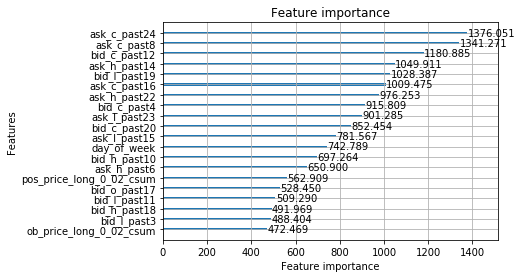

In [125]:
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=20)

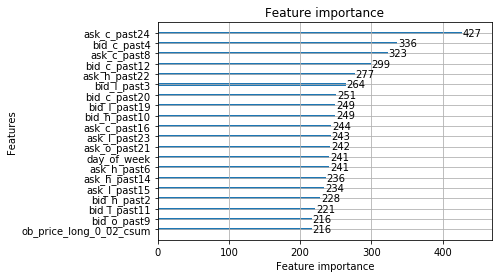

In [126]:
lgb.plot_importance(lgb_model, importance_type='split', max_num_features=20)

In [128]:
def tf_to_bin(value):
    if value:
        return 1
    else:
        return 0

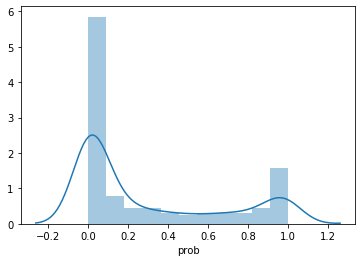

In [129]:
mds['prob'] =  lgb_model.predict(mds[model_cols])
sns.distplot(mds['prob'])

In [130]:
prob_df = pd.DataFrame()
counter = 1
for t in np.arange(0.1, 0.9, 0.0025):
    temp_test = mds.copy()
    temp_test['prob'] =  lgb_model.predict(temp_test[model_cols])
    temp_test['pred'] = temp_test['prob'].apply(lambda x: 1 if x >= t else 0)
    temp_test['tp'] = (temp_test['pred'] == 1) & (mds['long_target'] == 1)
    temp_test['fp'] = (temp_test['pred'] == 1) & (mds['long_target'] == 0)
    temp_test['tn'] = (temp_test['pred'] == 0) & (mds['long_target'] == 0)
    temp_test['fn'] = (temp_test['pred'] == 0) & (mds['long_target'] == 1)
    
    temp = pd.DataFrame()
    temp['cutoff'] = [t]
    temp['total_target'] = mds['long_target'].value_counts()[1]
    temp['tp_cnt'] =  temp_test['tp'].sum()
    temp['fp_cnt'] =  temp_test['fp'].sum()
    temp['tp_pct'] = (temp_test['tp'].sum() / temp_test[['tp', 'fp']].sum().sum())*100
    temp['fp_pct'] = (temp_test['fp'].sum() / temp_test[['tp', 'fp']].sum().sum())*100
    temp['tp_pct_total'] = (temp_test['tp'].sum() / temp_test[['tp', 'fn']].sum().sum())*100
    if counter == 1:
        prob_df = temp
        counter +=1
    else:
        prob_df = prob_df.append(temp)
        
prob_df['pct_diff'] = prob_df['tp_pct'] - prob_df['fp_pct']
prob_df['pct_diff'] = prob_df['tp_pct'] - prob_df['fp_pct']
prob_df['pl'] = (prob_df['tp_cnt'] * profit) - (prob_df['fp_cnt'] * loss)
positive = prob_df[prob_df['pl'] > 0].copy()
try:
    target_cutoff = positive[positive['pl'] == positive['pl'].max()]['cutoff'].values
    target_cutoff = target_cutoff[len(target_cutoff)-1]
except IndexError:
    print('error')
    target_cutoff= 0.5
# positive = prob_df[prob_df['pct_diff'] > 1].copy()
# target_cutoff_min = positive['cutoff'].min()
# target_cutoff_max = positive['cutoff'].max()
target_cutoff

0.8975000000000007

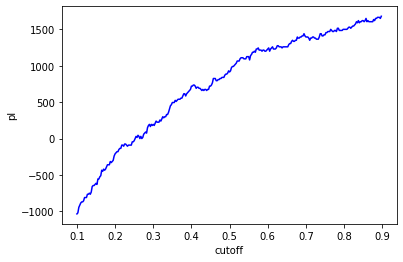

In [131]:
sns.lineplot(x='cutoff', y='pl', data=prob_df,  color='b')

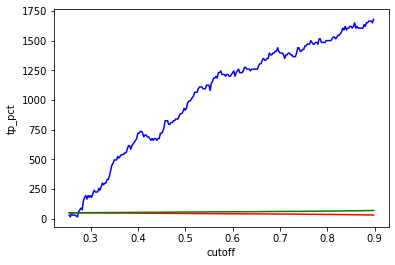

In [132]:
sns.lineplot(x='cutoff', y='pl', data=prob_df[prob_df['pl'] > 0],  color='b')
sns.lineplot(x='cutoff', y='fp_pct', data=prob_df[prob_df['pl'] > 0],  color='r')
sns.lineplot(x='cutoff', y='tp_pct', data=prob_df[prob_df['pl'] > 0],  color='g')

In [133]:
# mds = mds[mds['time'] >= '2019-01-01']
# mds.shape

0.8975000000000007
(288, 835)
End PL - $1680.0


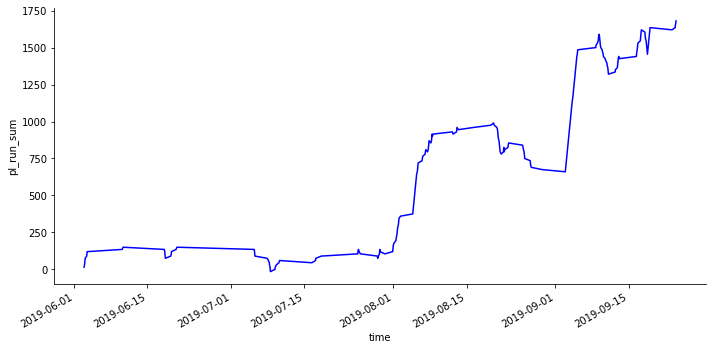

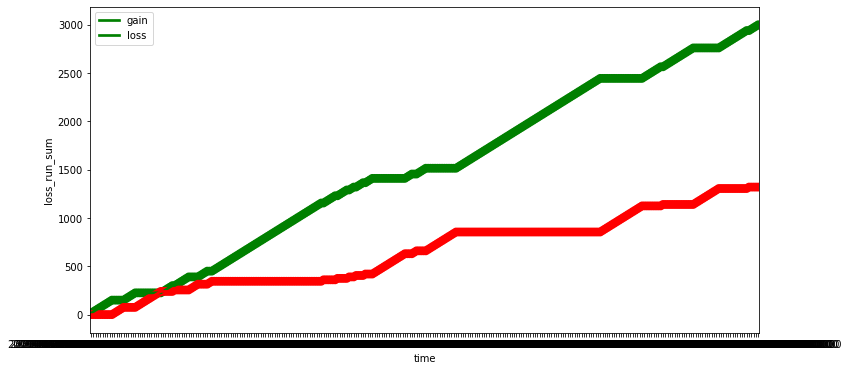

In [134]:
print(target_cutoff)
mds['prob'] = lgb_model.predict(mds[model_cols])
mds['pred'] = mds.apply(lambda x: 1 if x.prob >= target_cutoff else 0, axis=1)
mds['tp'] = (mds['pred'] == 1) & (mds['long_target'] == 1)
mds['fp'] = (mds['pred'] == 1) & (mds['long_target'] == 0)
mds['tn'] = (mds['pred'] == 0) & (mds['long_target'] == 0)
mds['fn'] = (mds['pred'] == 0) & (mds['long_target'] == 1)

mds['tp'] = mds['tp'].apply(tf_to_bin)
mds['fp'] = mds['fp'].apply(tf_to_bin)
mds['tn'] = mds['tn'].apply(tf_to_bin)
mds['fn'] = mds['fn'].apply(tf_to_bin)

tp = mds[mds['tp'] == 1].copy()
tp['pl'] = profit
tp['gain'] = profit
tp['loss'] = 0

fp = mds[mds['fp'] == 1].copy()
fp['pl'] = -loss
fp['gain'] = 0
fp['loss'] = loss

pl_df = pd.concat([tp, fp], axis=0)
pl_df['time'] = pd.to_datetime(pl_df['time'])
pl_df = pl_df.sort_values(by='time')
pl_df['pl_run_sum'] = pl_df['pl'].cumsum()
pl_df['gain_run_sum'] = pl_df['gain'].cumsum()
pl_df['loss_run_sum'] = pl_df['loss'].cumsum()
print(pl_df.shape)
print('End PL - ' + '$'+ str(pl_df['pl_run_sum'].tail(1).values[0]))

g = sns.relplot(x="time", y="pl_run_sum", kind="line", color='b', data=pl_df, height=5, aspect=2)
g.fig.autofmt_xdate()

fig, ax = plt.subplots(figsize=(12, 6))
sns.pointplot(x='time', y='gain_run_sum', data=pl_df, color='g')
sns.pointplot(x='time', y='loss_run_sum', data=pl_df, color='r')
plt.legend(['gain', 'loss'])
plt.show()

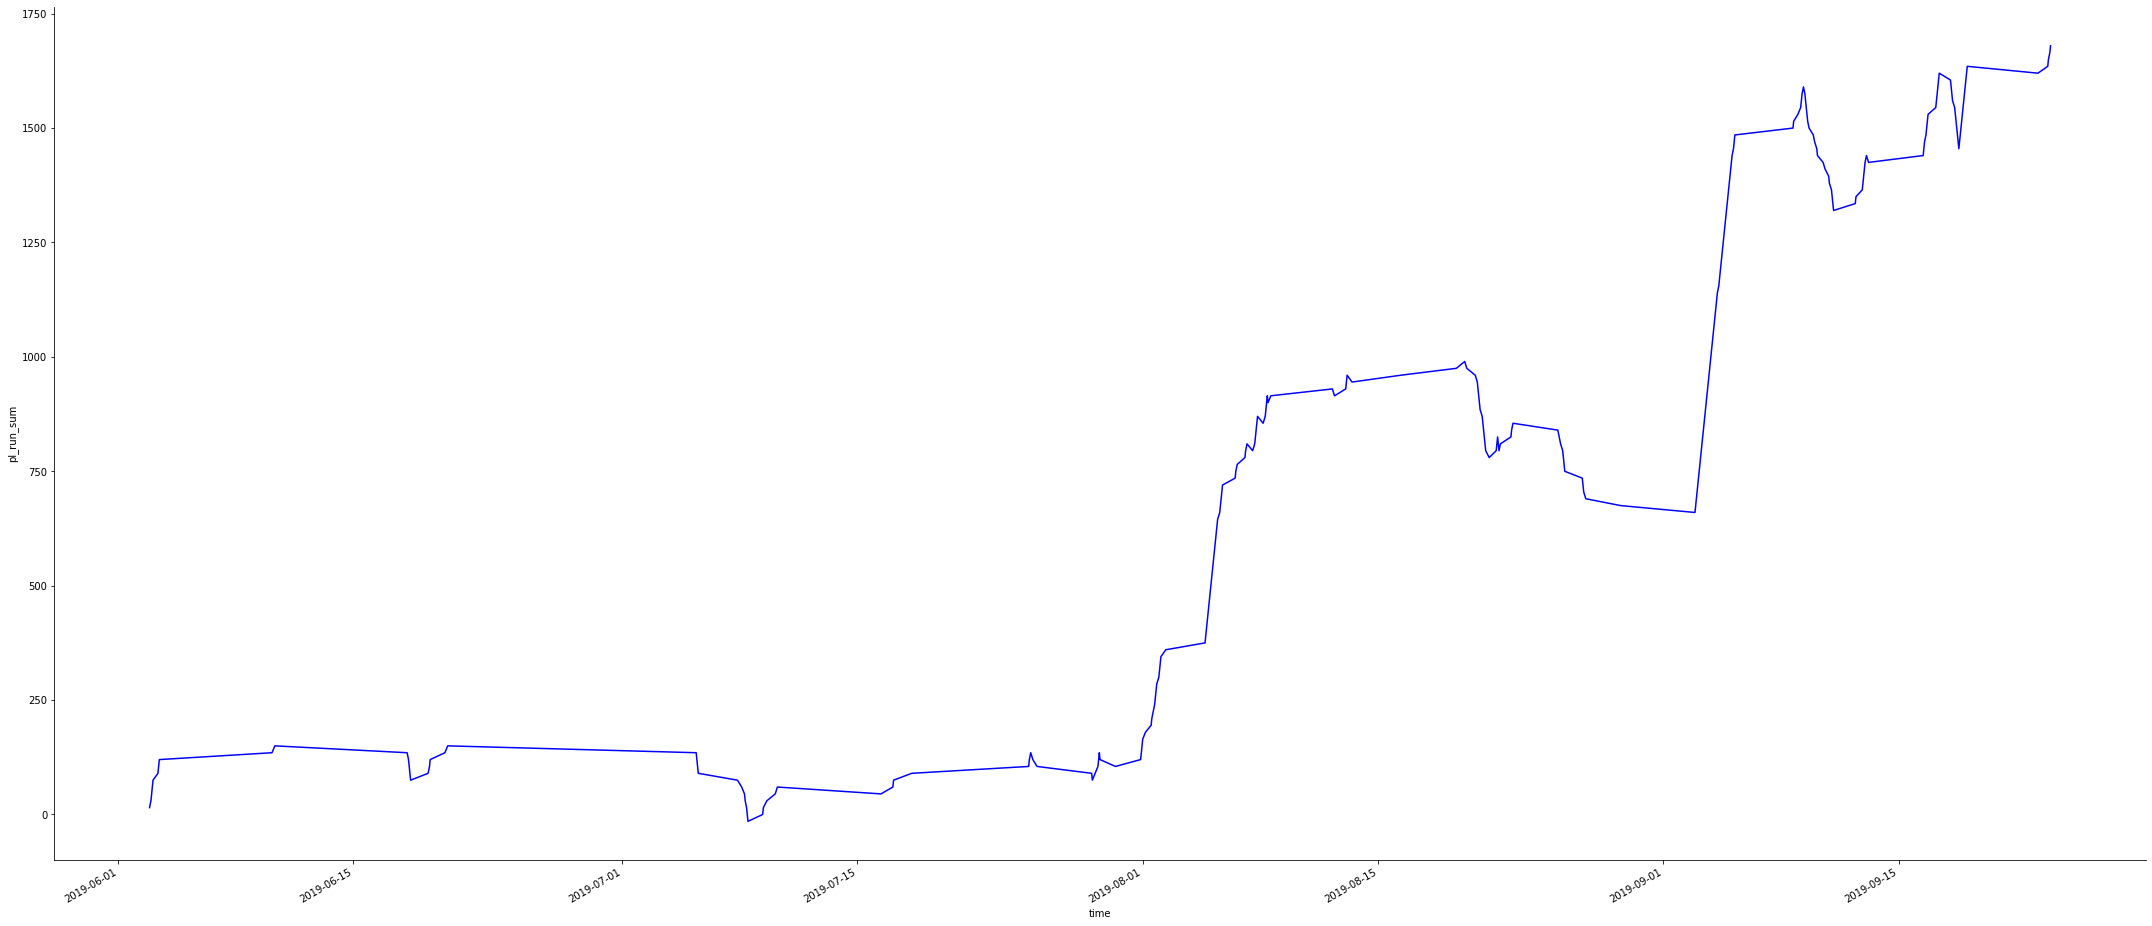

In [135]:
g = sns.relplot(x="time", y="pl_run_sum", kind="line", color='b', data=pl_df, height=15, aspect=2)
g.fig.autofmt_xdate()

In [136]:
tp_cnt = 0
fp_cnt = 0

pl_df = pl_df.reset_index(drop=True)
pl_df['index'] = pl_df.index
pl_df['tp_up1'] = pl_df['tp'].shift(1)
pl_df['fp_up1'] = pl_df['fp'].shift(1)
pl_df['win_streak'] = 0
pl_df['losing_streak'] = 0
pl_df['tp_runsum'] = pl_df['tp'].cumsum()


for idx, row in pl_df.iterrows():
    if row['tp'] == 1 and row['tp_up1'] != 1.0:
        pl_df.loc[idx, 'win_streak'] = row['win_streak'] +1
        
    elif row['tp'] == 1  and  row['tp_up1'] == 1.0:
        pl_df.loc[idx, 'win_streak'] = pl_df.loc[idx-1, 'win_streak'] +1

    else:
        pl_df.loc[idx, 'win_streak'] = 0
        
    if row['fp'] == 1 and row['fp_up1'] != 1.0:
        pl_df.loc[idx, 'losing_streak'] = row['win_streak'] +1
        
    elif row['fp'] == 1  and  row['fp_up1'] == 1.0:
        pl_df.loc[idx, 'losing_streak'] = pl_df.loc[idx-1, 'losing_streak'] +1

    else:
        pl_df.loc[idx, 'losing_streak'] = 0

win_streak_start = 1
loss_streak_stop = 1
trade_cols = ['time', 'tp', 'fp', 'win_streak', 'losing_streak', 'pl', 'live_pl', 'pl_run_sum', 'gain_run_sum', 'loss_run_sum']
trade_df = pd.DataFrame(columns=trade_cols)
idx_counter = 0
while idx_counter <= pl_df.index.max():
    safe = True
    failed = False
    while not failed:
        if idx_counter <= pl_df.index.max():
            temp = pl_df[pl_df['index'] == idx_counter].copy()
            if temp['losing_streak'].values[0] <= loss_streak_stop:
                temp['live_pl'] = temp['pl'].values[0]
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
                tp_cnt+=1
            else:
                temp['live_pl'] = 0
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
                failed = True
                fp_cnt+=1
        else:
            failed = True
#             fp_cnt+=1

    while failed:
        if idx_counter <= pl_df.index.max():
            temp = pl_df[pl_df['index'] == idx_counter].copy()
            if temp['win_streak'].values[0] <= win_streak_start:
                temp['live_pl'] = 0
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
#                 fp_cnt+=1
            else:
                temp['live_pl'] = temp['pl'].values[0]
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1 
                failed = False
#                 tp_cnt+1
        else:
            failed = False
#             tp_cnt+=1
            
for c in list(trade_df):
    if c != 'time':
        trade_df[c] = pd.to_numeric(trade_df[c])

trade_df['live_pl_run_sum'] = trade_df['live_pl'].cumsum()
trade_df['time'] = pd.to_datetime(trade_df['time'])

# g = sns.relplot(x="time", y="pl_run_sum", kind="line", color='b', data=trade_df, height=5, aspect=2)
# g.fig.autofmt_xdate()

print('orig total - $'  + str(trade_df['pl_run_sum'].tail(1).values[0]))
print('new total  - $' + str(trade_df['live_pl_run_sum'].tail(1).values[0]))

print(tp_cnt, fp_cnt)

orig total - $1680.0
new total  - $2610.0
199 9


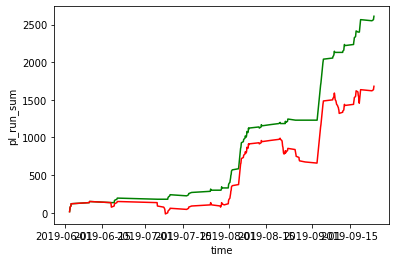

In [137]:
sns.lineplot(x='time', y='live_pl_run_sum', data=trade_df, color='g')
sns.lineplot(x='time', y='pl_run_sum', data=trade_df, color='r')

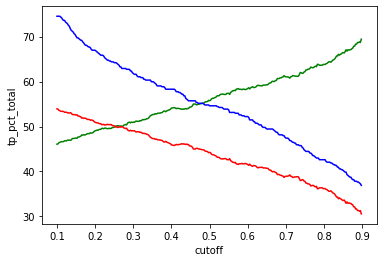

In [138]:
sns.lineplot(x='cutoff', y='tp_pct', data=prob_df, color='g')
sns.lineplot(x='cutoff', y='fp_pct', data=prob_df, color='r')
sns.lineplot(x='cutoff', y='tp_pct_total', data=prob_df, color='b')

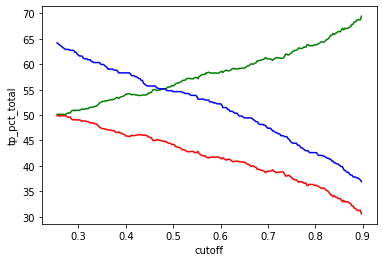

In [139]:
sns.lineplot(x='cutoff', y='tp_pct', data=positive, color='g')
sns.lineplot(x='cutoff', y='fp_pct', data=positive, color='r')
sns.lineplot(x='cutoff', y='tp_pct_total', data=positive, color='b')

In [140]:
mds['prob'] = lgb_model.predict(mds[model_cols])
mds['pred'] = mds.apply(lambda x: 1 if x.prob >= target_cutoff else 0, axis=1)
mds['tp'] = (mds['pred'] == 1) & (mds['long_target'] == 1)
mds['fp'] = (mds['pred'] == 1) & (mds['long_target'] == 0)
mds['tn'] = (mds['pred'] == 0) & (mds['long_target'] == 0)
mds['fn'] = (mds['pred'] == 0) & (mds['long_target'] == 1)

mds['tp'] = mds['tp'].apply(tf_to_bin)
mds['fp'] = mds['fp'].apply(tf_to_bin)
mds['tn'] = mds['tn'].apply(tf_to_bin)
mds['fn'] = mds['fn'].apply(tf_to_bin)

print(mds.shape)

tp = mds[mds['tp'] == 1].copy()
tp['pl'] = profit
tp['gain'] = profit
tp['loss'] = 0

fp = mds[mds['fp'] == 1].copy()
fp['pl'] = -loss
fp['gain'] = 0
fp['loss'] = loss

tn = mds[mds['tn'] == 1].copy()
tn['pl'] = 0
tn['gain'] = 0
tn['loss'] = 0

fn = mds[mds['fn'] == 1].copy()
fn['pl'] = 0
fn['gain'] = 0
fn['loss'] = 0

mds = pd.concat([tp, fp, tn, fn], axis=0)
mds = mds.sort_values(by='time')
print(mds.shape)

(1915, 829)
(1915, 832)


In [141]:
mcnt = mds.groupby(['month', 'tp', 'fp', 'fn', 'tn']).size().reset_index()
mcnt.columns = ['month', 'tp', 'fp', 'fn', 'tn', 'count']
mcnt.tail(15)

,month,tp,fp,fn,tn,count
1,6,0,0,1,0,170
2,6,0,1,0,0,5
3,6,1,0,0,0,15
4,7,0,0,0,1,448
5,7,0,0,1,0,68
6,7,0,1,0,0,18
7,7,1,0,0,0,18
8,8,0,0,0,1,357
9,8,0,0,1,0,57
10,8,0,1,0,0,33


In [142]:
pl_check = pd.concat([tp, fp], axis=0)

In [143]:
pl_check.groupby('month')['pl'].agg(['median', 'mean', 'sum', 'min', 'max', 'count'])

,median,mean,sum,min,max,count
month,,,,,,
6,15.0,7.500000,150.0,-15.0,15.0,20
7,0.0,0.000000,0.0,-15.0,15.0,36
8,15.0,5.198020,525.0,-15.0,15.0,101
9,15.0,7.671756,1005.0,-15.0,15.0,131


In [144]:
pl_check.groupby('day_of_week')['pl'].agg(['median', 'mean', 'sum', 'min', 'max', 'count'])

,median,mean,sum,min,max,count
day_of_week,,,,,,
0,15.0,5.434783,375.0,-15.0,15.0,69
1,15.0,4.384615,285.0,-15.0,15.0,65
2,15.0,4.736842,360.0,-15.0,15.0,76
3,15.0,10.714286,525.0,-15.0,15.0,49
4,15.0,3.461538,45.0,-15.0,15.0,13
6,15.0,5.625000,90.0,-15.0,15.0,16


In [145]:
pl_check.groupby('hour')['pl'].agg(['median', 'mean', 'sum', 'count'])

,median,mean,sum,count
hour,,,,
0,15.0,5.625000,90.0,16
1,15.0,8.076923,105.0,13
2,15.0,7.000000,105.0,15
3,15.0,3.461538,45.0,13
4,15.0,5.625000,90.0,16
5,15.0,2.142857,30.0,14
6,15.0,9.000000,90.0,10
7,15.0,2.500000,30.0,12
8,15.0,5.769231,75.0,13


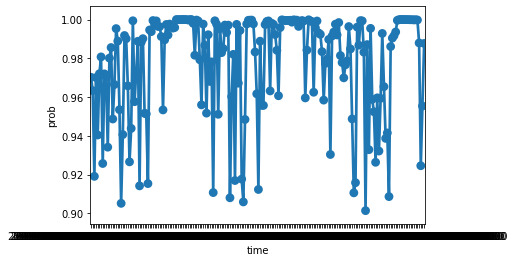

In [146]:
sns.pointplot(x='time', y='prob', data=tp)

In [147]:
tp['time'].tail(10)

6392   2019-09-18 21:00:00
6393   2019-09-18 22:00:00
6394   2019-09-18 23:00:00
6395   2019-09-19 00:00:00
6396   2019-09-19 01:00:00
6397   2019-09-19 02:00:00
6402   2019-09-23 21:00:00
6403   2019-09-23 22:00:00
6405   2019-09-24 00:00:00
6406   2019-09-24 01:00:00
Name: time, dtype: datetime64[ns]

In [148]:
#Precision
print(mds[['tp']].sum() / mds[['tp', 'fp']].sum().sum())
print()
print(mds[['tp']].sum() / mds[['tp', 'fn']].sum().sum())

tp    0.694444
dtype: float64

tp    0.369004
dtype: float64


In [149]:
mds.groupby(['tp', 'fp', 'tn', 'fn']).size()

tp  fp  tn  fn
0   0   0   1      342
        1   0     1285
    1   0   0       88
1   0   0   0      200
dtype: int64

In [150]:
62*30

1860

In [151]:
27*6

162

In [152]:
1860-162

1698

In [153]:
41*30

1230

In [154]:
103*5

515

In [155]:
t = mds[mds['long_target'] == 1]
t['prob'].describe()

count    542.000000
mean       0.548337
std        0.406770
min        0.000324
25%        0.097884
50%        0.637763
75%        0.972295
max        0.999997
Name: prob, dtype: float64

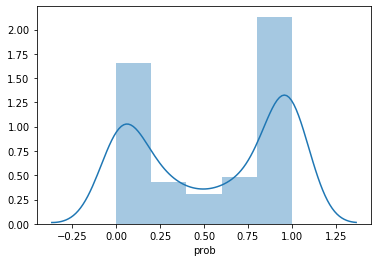

In [156]:
sns.distplot(t['prob'])

In [157]:
t['index'].min()

14444

In [158]:
t['index'].max()

16402

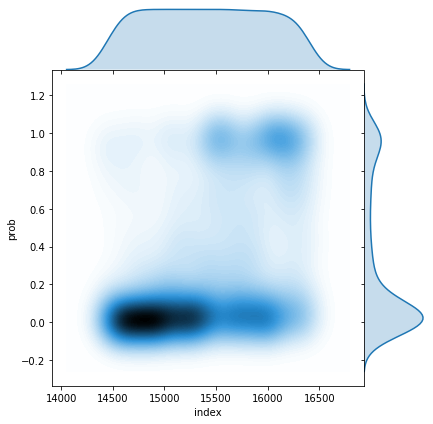

In [159]:
sns.jointplot(x='index', y='prob', data=mds, kind='kde', n_levels=100, space=0, zorder=0)

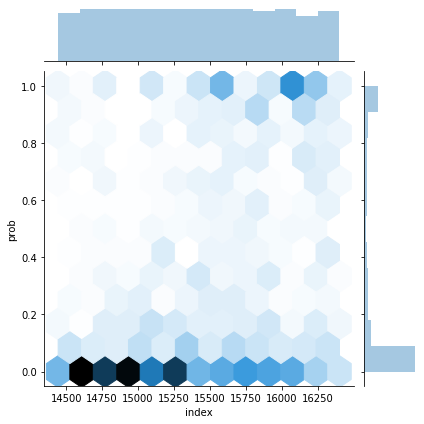

In [160]:
g = sns.jointplot(x='index', y='prob', data=mds, kind='hex')
g.savefig("probs_hex.png")

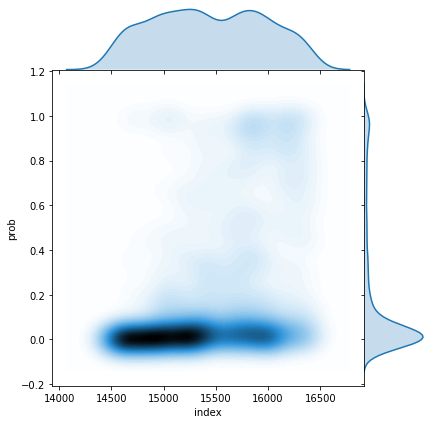

In [161]:
g = sns.jointplot(x='index', y='prob', data=mds[mds['long_target'] != 1], kind='kde', n_levels=100, space=0, zorder=0)
g.savefig("probs_fp_kde.png")

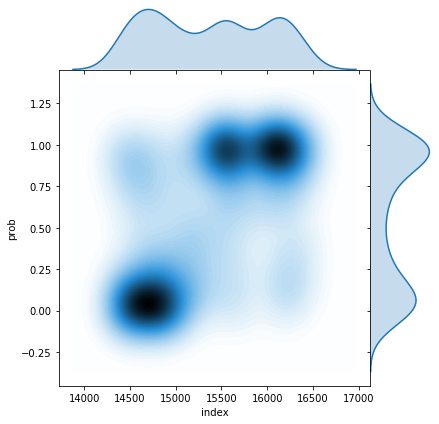

In [162]:
g = sns.jointplot(x='index', y='prob', data=mds[mds['long_target'] == 1], kind='kde', n_levels=100, space=0, zorder=0)
g.savefig("probs_tp_kde.png")

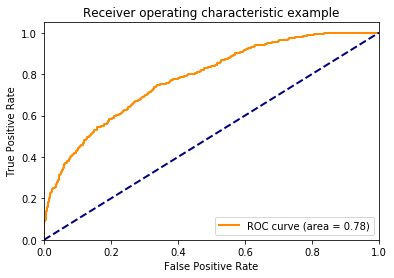

In [163]:
fpr, tpr, _ = roc_curve(mds['long_target'].values, mds['prob'].values )
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [164]:
features = list(X_train)
X = X_train.apply(pd.to_numeric).values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X)

C:\Users\bbennett\AppData\Roaming\Python\Python36\site-packages\shap\explainers\tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [165]:
shap_values = shap.TreeExplainer(lgb_model).shap_values(X)

C:\Users\bbennett\AppData\Roaming\Python\Python36\site-packages\shap\explainers\tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


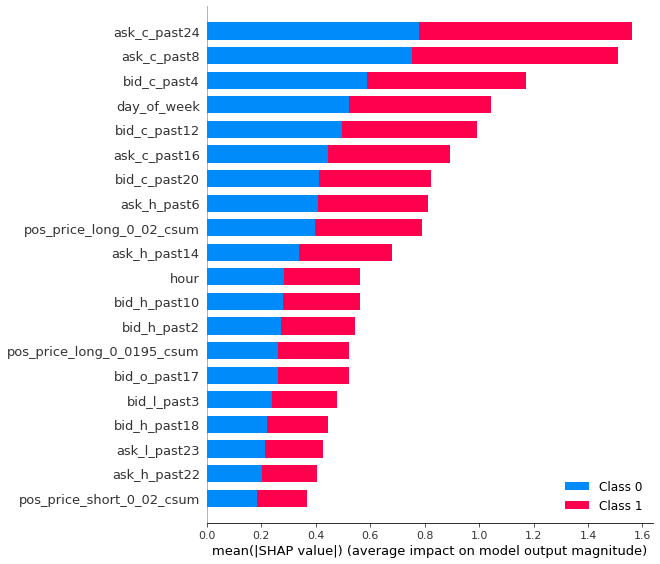

In [166]:
shap.summary_plot(shap_values, X_train)

In [167]:
# def get_top_feats(shap_values, num_feats):
#     feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0)[:-1])
#     feature_order = list(feature_order[-min(num_feats,len(feature_order)):])
#     feature_order = feature_order[::-1]
#     return list(X_train.iloc[:,feature_order])

# top_feats = get_top_feats(shap_values, 5)
# top_feats

In [168]:
# shap.dependence_plot('hour', shap_values, X, X_train.columns, interaction_index='auto',
#                              alpha=0.5, dot_size=5, show=False)

In [169]:
# shap.dependence_plot('day_of_week', shap_values, X, X_train.columns, interaction_index='auto',
#                              alpha=0.5, dot_size=5, show=False)


In [170]:
# for name in top_feats:
#     print(name)
#     shap.dependence_plot(name, shap_values, X, X_train.columns, interaction_index='auto',
#                              alpha=0.5, dot_size=5, show=False)
#     plt.show()

In [173]:
result_df = mds.copy()
result_df = result_df.sort_values(by='time')
result_df = result_df.reset_index(drop=True)
result_df['id'] = result_df.index
result_df.to_csv('long_preds_v3.csv', index=False, header=True)

In [174]:
lgb_model.save_model('../model/oanda_EURUSD_long_v10_long.txt', num_iteration=-1)
layout_df = pd.DataFrame(list(X_train), columns=['features'])
layout_df.to_csv('../model/oanda_EURUSD_long_v10_layout_long.csv', index=False, header=True)

info_df = pd.DataFrame()
info_df['long_target_diff'] = [target_diff]
info_df['long_stop_loss'] = stop_loss
info_df['l_target_cutoff'] = target_cutoff
info_df['l_profit'] = profit
info_df['l_loss'] = loss

info_df.to_csv('../model/oanda_EURUSD_long_v10_info_long.csv', index=False, header=True)

In [ ]:
mds[['time', 'long_target', 'prob', 'pred', 'tp', 'fp', 'tn', 'fn', 'pl', 'gain', 'loss']].to_csv('../data/oanda_EURUSD_long_v10_long_preds.csv', index=False)

In [ ]:
profit